In [1]:
#inventory management + v5

In [2]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta

import matplotlib.pyplot as plot
import networkx as nx

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [3]:
#id directories
data_dir = os.getcwd().replace('/model', '/data')
results_dir = os.getcwd().replace('/model', '/results')

In [4]:
CAP_reliability = -1 # -1 if 1 sd below mean, -2 if 2 sd below mean
DEMAND_reliability = 1 #1 if 1 sd above mean, 2 if 2 sd above mean

budget_level = 8
warehouse_cap_level = 1 #time intervals of supply that can be stored

In [5]:
#define sets
K = 1
I = 4
T = 10

In [6]:
#define parameters

#rank
r_k_dict = {
    1 : 1
}

#quality (supplier 4 has the highest quality)
q_k_i_dict = {
    tuple([1,1]) : 3,
    tuple([1,2]): 2,
    tuple([1,3]): 2,
    tuple([1,4]): 2
}

#starting inventory
z_k_i_init_dict = {
    tuple([1,1]) : 11918/4,
    tuple([1,2]) : 11918/4,
    tuple([1,3]) : 11918/4,
    tuple([1,4]) : 11918/4
}

alpha_k_init_dict = {
    1 : 1000
}

#lead time (supplier 3 has the lowest lead time)
f_k_i_tDiff_dict = {}

for k in range(1,K+1):
    for i in range(1,I+1):
        for t in range(T+1):
            if (i == 3):
                if (t == 0):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                elif (t == 1):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                elif (t == 2):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                elif (t == 3):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                else:
                    f_k_i_tDiff_dict[tuple([k,i,t])] = 0
            else:
                if (t == 3):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                elif (t == 4):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                elif (t == 5):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                elif (t == 6):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                else:
                    f_k_i_tDiff_dict[tuple([k,i,t])] = 0
                    

o_k_i_t_dict = {}

for k in range(1,K+1):
    for i in range(1,I+1):
        for t in range(1,T+1):
            if t < 4:
                o_k_i_t_dict[tuple([k,i,t])] = 2000
            else:
                o_k_i_t_dict[tuple([k,i,t])] = 0
                    
#size
s_k_dict = {
    1 : .5
}

#warehouse capacity
h = 11918*.5*warehouse_cap_level #assuming warehouse capacity is not an issue

#cost (supplier 2 has the lowest cost)
c_k_i_dict = {
    tuple([1,1]) : 1,
    tuple([1,2]) : .8,
    tuple([1,3]) : 1,
    tuple([1,4]) : 1
}

b = 11918*budget_level

#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict_mu_sd = {}

for k in range(1,K+1):
    for i in range(1,I+1):
        for t in range(T+1):
            if (i == 1):
                CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [20000, 20000*.1]
            else:
                CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [10000, 10000*.1]

D_k_t_dict_mu_sd = {
    tuple([1,1]) : [11800, 118],
    tuple([1,2]) : [11800, 118],
    tuple([1,3]) : [11800, 118],
    tuple([1,4]) : [11800, 118],
    tuple([1,5]) : [11800, 118],
    tuple([1,6]) : [11800, 118],
    tuple([1,7]) : [11800, 118],
    tuple([1,8]) : [11800, 118],
    tuple([1,9]) : [11800, 118],
    tuple([1,10]) : [11800, 118]
}

In [7]:
#data checks

mu = 0

for k in range(K):
    for t in range(T):
        mu = D_k_t_dict_mu_sd.get(tuple([k+1,t+1]))[0] + mu


check = np.zeros(I)

for k in range(1,K+1):
    for i in range(1,I+1):
        for t in range(T+1):
            check[i-1] = f_k_i_tDiff_dict.get(tuple([k,i,t])) + check[i-1]

In [8]:
model = ConcreteModel()

#####define sets#######
model.K = Set(initialize = range(1,K+1))
model.I = Set(initialize = range(1,I+1))
model.T = Set(initialize = range(1,T+1))

####initialize parameters####

def rank_param_initialize(model, k):
    return(r_k_dict.get(k))

model.r_k = Param(model.K, initialize = rank_param_initialize)

model.r_k.pprint()

def penalty_param_initialize(model, k):
    return(1/model.r_k[k])

model.p_k = Param(model.K, initialize = penalty_param_initialize)

model.p_k.pprint()

def discount_param_initialize(model, k, t):
    discount_temp = model.p_k[k]
    #time_diff = T-t
    return(1/((1+discount_temp)**(t-1)))

model.tau_k_t = Param(model.K, model.T, initialize = discount_param_initialize)

model.tau_k_t.pprint()

def quality_param_initialize(model, k, i):
    return(q_k_i_dict.get(tuple([k,i])))

model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

model.q_k_i.pprint()

def beg_inv_param_initialize(model, k, i):
    return(z_k_i_init_dict.get(tuple([k,i])))

model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

model.z_k_i_init.pprint()

def unfulfilled_demand_param_initialize(model, k):
    return(alpha_k_init_dict.get(k))

model.alpha_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

model.alpha_k_intialize.pprint()

def delay_dist_param_initialize(model, k, i, t):
    return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

model.f_k_i_tDiff = Param(model.K, model.I, model.T, initialize = delay_dist_param_initialize)

model.f_k_i_tDiff.pprint()

def incoming_orders_initialize(model, k, i, t):
    return(o_k_i_t_dict.get(tuple([k,i,t])))

model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

model.o_k_i_t.pprint()

def item_size_param_initialize(model, k):
    return(s_k_dict.get(k))

model.s_k = Param(model.K, initialize = item_size_param_initialize)

model.s_k.pprint()

def warehouse_cap_param_initialize(model):
    return(h)

model.h = Param(initialize = h)

model.h.pprint()

def cost_param_initialize(model, k, i):
    return(c_k_i_dict.get(tuple([k,i])))

model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

model.c_k_i.pprint()

def budget_param_initialize(model):
    return(b)

model.b = Param(initialize = budget_param_initialize)

model.b.pprint()

def supplier_cap_param_initialize(model, k, i, t):
    temp = CAP_k_i_t_dict_mu_sd.get(tuple([k,i,t]))
    mean = temp[0]
    sd = CAP_reliability*temp[1]
    return(mean+sd)

model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

model.cap_k_i_t.pprint()

#assume preparing for one sd above the mean
def mu_plus_sigma_demand_param_initialize(model, k, t):
    temp = D_k_t_dict_mu_sd.get(tuple([k,t]))
    mean = temp[0]
    sd = DEMAND_reliability*temp[1]
    return(mean+sd)

model.d_k_t = Param(model.K, model.T, initialize = mu_plus_sigma_demand_param_initialize)

model.d_k_t.pprint()

####initialize variables####
model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
model.alpha_k_t = Var(model.K, model.T, within = NonNegativeReals)
model.beta_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)

r_k : Size=1, Index=K, Domain=Any, Default=None, Mutable=False
    Key : Value
      1 :     1
p_k : Size=1, Index=K, Domain=Any, Default=None, Mutable=False
    Key : Value
      1 :   1.0
tau_k_t : Size=10, Index=tau_k_t_index, Domain=Any, Default=None, Mutable=False
    Key     : Value
     (1, 1) :         1.0
     (1, 2) :         0.5
     (1, 3) :        0.25
     (1, 4) :       0.125
     (1, 5) :      0.0625
     (1, 6) :     0.03125
     (1, 7) :    0.015625
     (1, 8) :   0.0078125
     (1, 9) :  0.00390625
    (1, 10) : 0.001953125
q_k_i : Size=4, Index=q_k_i_index, Domain=Any, Default=None, Mutable=False
    Key    : Value
    (1, 1) :     3
    (1, 2) :     2
    (1, 3) :     2
    (1, 4) :     2
z_k_i_init : Size=4, Index=z_k_i_init_index, Domain=Any, Default=None, Mutable=False
    Key    : Value
    (1, 1) : 2979.5
    (1, 2) : 2979.5
    (1, 3) : 2979.5
    (1, 4) : 2979.5
alpha_k_intialize : Size=1, Index=K, Domain=Any, Default=None, Mutable=False
    Key : Value
   

In [9]:
#def initialize_objective(model):
model.Objective = Objective(expr = 
                            (sum(model.q_k_i[k,i]*sum(model.tau_k_t[k,t]*model.beta_k_i_t[k,i,t] 
                                                      for t in model.T) 
                                 for i in model.I for k in model.K)),
                            sense = maximize)

In [10]:
def beggining_inventory_constraint_initialize(model, k, i):
    return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])
    
model.beggining_inventory_constraint = Constraint(model.K, model.I, 
                                                  rule = beggining_inventory_constraint_initialize)

In [11]:
def initalize_unsatisfied_demand_constraint_initialize(model, k):
    return(model.alpha_k_t[k,1] == model.alpha_k_intialize[k])

model.initalize_unsatisfied_demand_constraint_initialize = \
Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

In [12]:
def incoming_orders_constraint_initialize(model, k, i, t):
    return(model.y_k_i_t[k,i,t] - 
           sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
               for t_ordered_time in range(1,t)) - model.o_k_i_t[k,i,t] == 0)

model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                               rule = incoming_orders_constraint_initialize)

In [13]:
def calculate_available_inventory_constraint_initialize(model, k, i, t):
    if (t > 1):
        return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + model.beta_k_i_t[k,i,t-1] == 0)
    else:
        return(Constraint.Skip)
    
model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                            rule = 
                                                            calculate_available_inventory_constraint_initialize)

In [14]:
def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
    return(model.beta_k_i_t[k,i,t] - model.z_k_i_t[k,i,t] <= 0)

model.cannot_fulfill_more_than_available_constraint = \
Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

In [15]:
def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
    if t > 1:
        return(model.alpha_k_t[k,t] - model.alpha_k_t[k,t-1] + sum(model.beta_k_i_t[k,i,t] for i in model.I) == \
               model.d_k_t[k,t])
    else:
        return(Constraint.Skip)

model.calculate_unsatisfied_demand_constraint = \
Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)

In [16]:
def warehouse_capacity_constraint_initialize(model, t):
    return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

model.warehouse_capacity_constraint = \
Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

In [17]:
def budget_constraint_initialize(model):
    return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
               for k in model.K for i in model.I for t in model.T) 
           <= model.b)

model.budget_constraint = \
Constraint(rule = budget_constraint_initialize)

In [18]:
def supplier_constraint_initialize(model, k, i, t):
    return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

model.supplier_constraint = \
Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)

In [19]:
opt = SolverFactory('gurobi_persistent')
opt.set_instance(model)
opt.solve(model)

Using license file /Users/chelseagreene/gurobi.lic
Academic license - for non-commercial use only


{'Problem': [{'Name': 'unknown', 'Lower bound': 48721.6078125, 'Upper bound': 48721.6078125, 'Number of objectives': 1, 'Number of constraints': 181, 'Number of variables': 170, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 170, 'Number of nonzeros': 533, 'Sense': -1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.01', 'Status': 'ok', 'Wallclock time': 0.0038330554962158203, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [20]:
#extract ordering df
ordered_df = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
ordered_df.loc[:,'item_type']=ordered_df.sets.map(lambda x:x[0])
ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[1])
ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[2])

In [21]:
#extract expected arrivals df
recieved_df = pd.DataFrame(list(model.y_k_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
recieved_df.loc[:,'item_type']=recieved_df.sets.map(lambda x:x[0])
recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[1])
recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[2])

In [22]:
#extract expected fulfilled df
fulfilled_df = pd.DataFrame(list(model.beta_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])

In [23]:
#extract expected available df
available_df = pd.DataFrame(list(model.z_k_i_t.extract_values().items()),columns = ['sets','units_available'])
available_df.loc[:,'item_type']=available_df.sets.map(lambda x:x[0])
available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[1])
available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[2])

In [24]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.alpha_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

In [25]:
unsatisfied_df

,sets,units_unsatisfied,item_type,time_interval
0,"(1, 1)",1000.0,1,1
1,"(1, 2)",4918.0,1,2
2,"(1, 3)",6136.0,1,3
3,"(1, 4)",6136.0,1,4
4,"(1, 5)",6136.0,1,5
5,"(1, 6)",6136.0,1,6
6,"(1, 7)",6136.0,1,7
7,"(1, 8)",6136.0,1,8
8,"(1, 9)",6136.0,1,9
9,"(1, 10)",7591.6,1,10


In [26]:
demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])

In [27]:
ordered_and_recieved_df = ordered_df[['item_type', 'supplier', 'time_interval', 'sets']]
ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                        on='sets', how='left')
ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                        on='sets', how='left')

ordered_and_recieved_df = ordered_and_recieved_df[['item_type', 'supplier', 
                                                   'time_interval','units_to_order', 
                                                   'expected_units_recieved']]

ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)

In [28]:
os.chdir(results_dir)
ordered_and_recieved_df.to_csv('ordering_and_recieving_schedule.csv')

In [29]:
demand_df

,sets,demand_in_units,item_type,time_interval
0,"(1, 1)",11918,1,1
1,"(1, 2)",11918,1,2
2,"(1, 3)",11918,1,3
3,"(1, 4)",11918,1,4
4,"(1, 5)",11918,1,5
5,"(1, 6)",11918,1,6
6,"(1, 7)",11918,1,7
7,"(1, 8)",11918,1,8
8,"(1, 9)",11918,1,9
9,"(1, 10)",11918,1,10


In [30]:
unsatisfied_df

,sets,units_unsatisfied,item_type,time_interval
0,"(1, 1)",1000.0,1,1
1,"(1, 2)",4918.0,1,2
2,"(1, 3)",6136.0,1,3
3,"(1, 4)",6136.0,1,4
4,"(1, 5)",6136.0,1,5
5,"(1, 6)",6136.0,1,6
6,"(1, 7)",6136.0,1,7
7,"(1, 8)",6136.0,1,8
8,"(1, 9)",6136.0,1,9
9,"(1, 10)",7591.6,1,10


In [31]:
s1_fulfilled = fulfilled_df[fulfilled_df['supplier'] == 1]
s2_fulfilled = fulfilled_df[fulfilled_df['supplier'] == 2]
s3_fulfilled = fulfilled_df[fulfilled_df['supplier'] == 3]

In [32]:
#new demand + demand from the day before
total_demand_df = unsatisfied_df[['time_interval', 'units_unsatisfied']]
total_demand_df['total_demand'] = demand_df['demand_in_units'] + unsatisfied_df['units_unsatisfied']

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


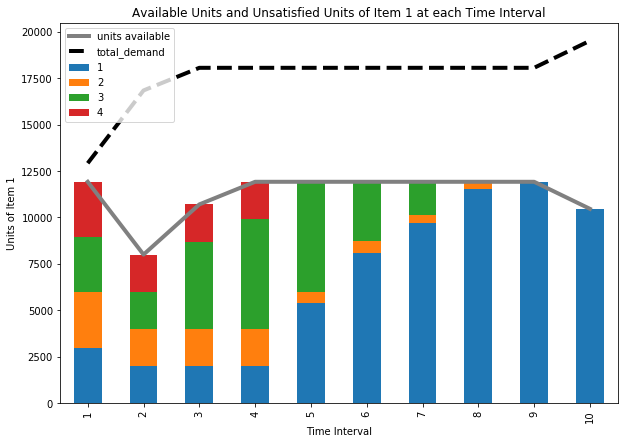

In [36]:
#stacked bar (fulfilled demand)
pivot_df = fulfilled_df.pivot(index='time_interval', columns='supplier', values='units_fulfilled')
pivot_df.plot.bar(stacked=True, figsize=(10,7), )

#units available
available_overtime_df = available_df.groupby(['time_interval'])["units_available"].sum().reset_index()
plot.plot(available_overtime_df['time_interval']-1, 
          available_overtime_df['units_available'], 
          label='units available',
          color ="grey",
         linewidth=4) 

#new demand + demand from the day before
total_demand = demand_df['demand_in_units'] + unsatisfied_df['units_unsatisfied']
plot.plot(available_overtime_df['time_interval']-1, 
          total_demand, 
          label='total_demand',
         linestyle='dashed',
          color="black",
          linewidth=4) 

plot.xlabel('Time Interval')
plot.ylabel('Units of Item 1')
plot.title('Available Units and Unsatisfied Units of Item 1 at each Time Interval')
plot.legend()
plot.savefig('available_and_unsatisfied_lineplot.jpg')

In [37]:
pos_dict_all = {}
label_dict_all = {}
color_dict_all = {}
G_dict_all = {}

In [38]:
for i in range(1,I+1):
    G=nx.Graph()
    label_dict = {}
    color_map = []
    
    global ordered_df
    global recieved_df
    
    time_coordinates = range(1,T+1)
    ordered_amount_coordinates = np.array(ordered_df[(ordered_df['supplier'] == i)]['units_to_order'])
    recieved_amount_coordinates = np.array(recieved_df[(recieved_df['supplier'] == i)]['expected_units_recieved'])

    for t in range(T):
        ordered_amount = ordered_amount_coordinates[t]
        recieved_amount = recieved_amount_coordinates[t]

        if (ordered_amount > 0):
            name = str(t) + 'planned units to order' + str(ordered_amount)
            G.add_node(name, pos = (t+1,1))
            label_dict[name] = round(ordered_amount).astype(int)
            color_map.append('blue')

        if (recieved_amount > 0):
            name = str(t) + 'expected number of units recieved' + str(recieved_amount)
            G.add_node(name, pos = (t+1,2))
            label_dict[name] = round(recieved_amount).astype(int)
            color_map.append('green')

    pos=nx.get_node_attributes(G,'pos')
    label_dict_all['supplier' + str(i)] = label_dict
    color_dict_all['supplier' + str(i)] = color_map
    pos_dict_all['supplier' + str(i)] = pos
    G_dict_all['supplier' + str(i)] = G

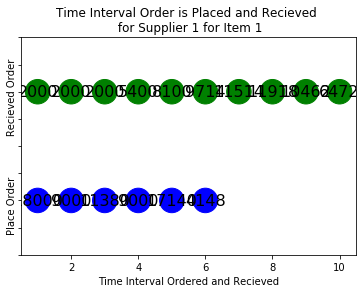

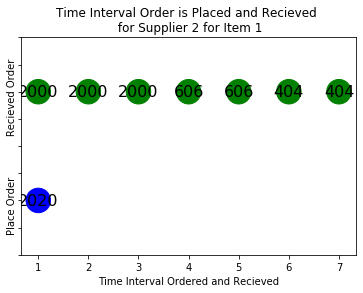

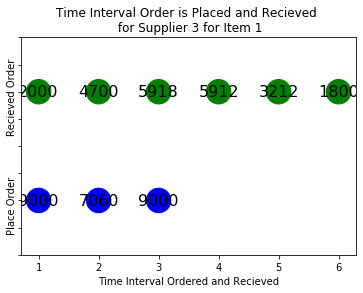

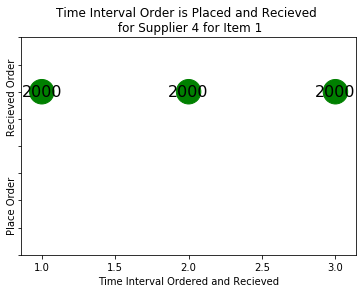

In [39]:
for i in range(1, I+1):

    fig, ax = plot.subplots()
    nx.draw(G_dict_all.get('supplier' + str(i)),
            pos_dict_all.get('supplier' + str(i)), 
            labels=label_dict_all.get('supplier' + str(i)), 
            node_size=600, font_size=16, with_labels = True, 
            node_color=color_dict_all.get('supplier' + str(i)), 
            ax = ax)
    ax.set_xlabel('Time Interval Ordered and Recieved')
    ax.set_ylabel('Place Order             Recieved Order')
    ax.set(ylim=(.5, 2.5))
    ax.set_title('Time Interval Order is Placed and Recieved \n for Supplier '+ str(i)+' for Item 1')
    ax.tick_params(left=True, bottom=True, labelleft=False, labelbottom=True)
    limits=plot.axis('on')
    plot.savefig('Item_1_Supplier' + str(i)+'.jpg')